# Lab4.2 Testing and evaluating an emotion text classifier

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

In notebook Lab4.2, we analysed the training and test data and in Lab4.3, we tested the trained SVM classifier on the test set. The results were mixed, at least partly due to thedominance of the ```neutral``` class and partly due to underpresentation of emotions such as ```disgust``` and ```fear```.

In this notebook, we discuss anumber of adjustement that can be made to the classifier:

1. Adjusting the parameters for the CountVectorizer
2. Balancing the training data
3. Adjusting the parameters of the SVM classifier


## 1. Adjusting the parameters for the CountVectorizer

When we defined the CountVectorizer in Lab3, we selected frequency thresholds for the Bag-of-Word representation of the text and we used a stopword list to filter words. Lab4.2, we analysed the vocabulary of the train and test data, showing  Having more precise information about the frequency distributions of the tokens in the train and test set, we can inspect the vocabulary and make sure that words that we consider important for emotion detection are kept, whereas other words are removed.

This may force the classifier to use the words that matter and not lean so-called ```shortcuts``` that may work for this data but not for other data. A shortcut is a feature that predicts the right category in a data set very well but for the wrong reasons. Imagine that one of the characters in ```Friends``` often is sad. In that case the classifier may learn that mentioning this person in the utterance predicts the emotion ```sadness```. Obviously this will not work in other data in which another person is mentioned with the same name.

We will not go further into demonstrating how this can be adjusted but leave this up to you to experiment. You can analyse the vocabulary further and define different frequency threshold to exclude certain words as features or create a dedicated stoplist, e.g. containing long words and people's names to prevent shortcuts to be learned.

A rule of thumb for the size of the vocabulary is the following:

```
    The more dimensions (words in a BoW representation), the more training data you need to learn their value for the categories.
```

Lowering the frequency threshold, means increasing the vocabulary and therefore increasing the dimensions. This could be a strategy if also more training data is collected.

## 2. Balancing training data 

We have seen in notebook Lab4.3 that our system performs just above the baseline of the dominant class *neutral*: .47. What can you do if one class is so dominant?
Well, we can simply reduce the training data for the dominant class. The next code iterates over the utterances and emotions labels and keeps one-fifth.

We first import the training data again.

In [52]:
filepath = '../Lab3.machine_learning/data/MELD/train_sent_emo.csv'
# Create a dataframe object 'dftrain' by readig the file.
dftrain = pd.read_csv(filepath)

Using the ```zip``` function, we pair the utterances and the emotion label and iterate over the items. We set the sample size to 5 and if the emotion is neutral we keep one out the sample size. You can easily change this to get more or less or to filter on other emotions or even selecting utterances with certain words in it or certain length.

In [54]:
## With sample we define how many training cases we want to skip to select the next training item
## If set to 5 we take 1 out of 5 when the emotion is neutral
sample = 5

balanced_training_instances=[]
balanced_training_labels=[]

cnt_neutral = 0
for utterance, emotion_label in zip(dftrain['Utterance'], dftrain['Emotion']):
    if emotion_label =='neutral':
        cnt_neutral += 1
        if cnt_neutral % sample == 0:  ### this checks if the count is dividable by the value of sample (no leftover)
            balanced_training_instances.append(utterance)
            balanced_training_labels.append(emotion_label)
    else:
        balanced_training_instances.append(utterance)
        balanced_training_labels.append(emotion_label)
        
print('Original data size', len(dftrain['Utterance']))
print('Sampled data size', len(balanced_training_instances))

Original data size 9989
Sampled data size 6221


To visualise the new distribution, we put the balanced labels in a new Pandas dataframe.

In [55]:
balanced_df = pd.DataFrame(balanced_training_labels, columns = ['Emotion'])
print(balanced_df.info())
print(balanced_df.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6221 entries, 0 to 6220
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Emotion  6221 non-null   object
dtypes: object(1)
memory usage: 48.7+ KB
None
     Emotion
0   surprise
1    neutral
2       fear
3    neutral
4   surprise
5   surprise
6    sadness
7   surprise
8       fear
9    neutral
10       joy
11   sadness
12  surprise
13   disgust
14   sadness


In [56]:
import seaborn as sns

#### Adding proportions to plotted labels counts
def plot_labels_with_counts(labels, values):
    total = 0
    total = sum(values)
   # print('Total of values', total)
    ax = sns.barplot(x=labels, y=values)
    # Add values above bars
    for i, v in enumerate(values):
        ax.text(i, v + 0.2, str(int((v/total*100)))+'%', ha='center')
    plt.show()

['joy', 'surprise', 'anger', 'neutral', 'sadness', 'disgust', 'fear'] [1743, 1205, 1109, 942, 683, 271, 268]


/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


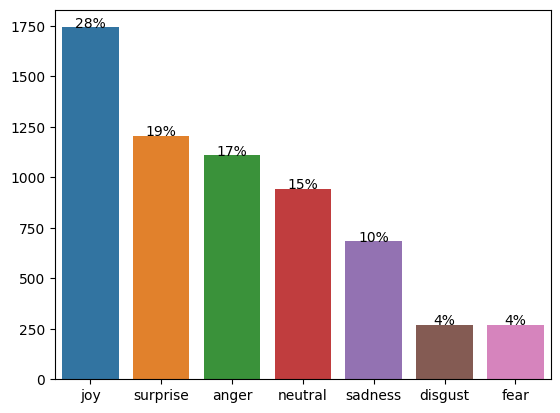

In [57]:
counts = balanced_df.Emotion.value_counts()
labels = counts.index.to_list()
values = counts.to_list()
print(labels, values)
plot_labels_with_counts(labels, values)

Will any of this work? To figure this out we need to retrain and test a new classifier with the new data.

### 2.1 Rebuild the vectorizer and train a new model

In [68]:
import sklearn
import numpy
import nltk
from sklearn import svm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
frequency_threshold = 5
utterance_vec_down_sampled =CountVectorizer(min_df=frequency_threshold, 
                             tokenizer=nltk.word_tokenize, 
                             stop_words=stopwords.words('english'))
count_vectors_down_sampled = utterance_vec_down_sampled.fit_transform(balanced_training_instances)
tfidf_transformer_down_sampled = TfidfTransformer()
training_tfidf_vectors_down_sampled = tfidf_transformer_down_sampled.fit_transform(count_vectors_down_sampled)
svm_linear_clf_down_sampled = svm.LinearSVC(max_iter=2000)
svm_linear_clf_down_sampled.fit(training_tfidf_vectors_down_sampled, balanced_training_labels)

/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


LinearSVC(max_iter=2000)

## 2.2 Load and represent the test data

In [69]:
import pandas as pd

filepath = '../Lab3.machine_learning/data/MELD/test_sent_emo.csv'
# Create a dataframe object 'dtest' by readig the file.
dftest = pd.read_csv(filepath)
dftest.info()
test_instances=dftest['Utterance']
test_labels = dftest['Emotion']
test_count_vectors = utterance_vec_down_sampled.transform(test_instances)
test_tfidf_vectors = tfidf_transformer_down_sampled.transform(test_count_vectors)
y_pred_svm = svm_linear_clf_down_sampled.predict(test_tfidf_vectors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


Downsampled BoW TFIDF SVM LINEAR ----------------------------------------------------------------
              precision    recall  f1-score   support

       anger      0.256     0.261     0.259       345
     disgust      0.129     0.059     0.081        68
        fear      0.036     0.020     0.026        50
         joy      0.311     0.629     0.416       402
     neutral      0.751     0.447     0.561      1256
     sadness      0.240     0.236     0.238       208
    surprise      0.373     0.577     0.453       281

    accuracy                          0.430      2610
   macro avg      0.300     0.318     0.290      2610
weighted avg      0.507     0.430     0.439      2610

Downsampled Confusion matrix SVM
['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
[[ 90   2   2 139  40  21  51]
 [ 14   4   2  15  16   5  12]
 [ 13   1   1  17   5   8   5]
 [ 32   5   2 253  55  20  35]
 [147  17  17 276 562  90 147]
 [ 36   2   3  50  46  49  22]
 [ 19   0   1  64  24 

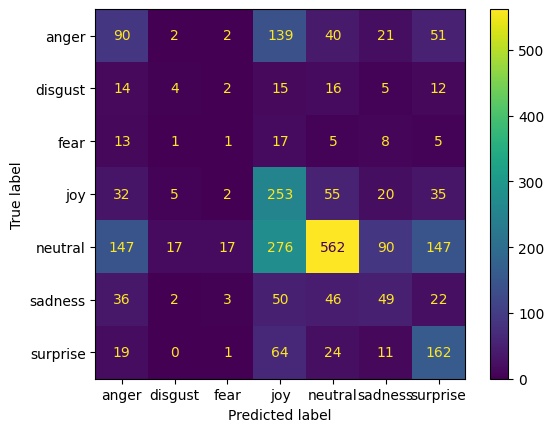

In [71]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

report = classification_report(test_labels,y_pred_svm,digits = 3, target_names = svm_linear_clf_down_sampled.classes_)
print('Downsampled BoW TFIDF SVM LINEAR ----------------------------------------------------------------')
print(report)

print('Downsampled Confusion matrix SVM')
print(svm_linear_clf_down_sampled.classes_)
cf_matrix_svm = confusion_matrix(test_labels,y_pred_svm)
print(cf_matrix_svm)
import matplotlib.pyplot as plt
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_svm, display_labels=svm_linear_clf_down_sampled.classes_)
display.plot()

Did the results improve? Well, the results are different. For sure ```neutral``` is less dominant. The precision went up from .64 to .75 and the recall went down from .86 to .44. For the other categories, we see only small differences.

In the confusion matrix, we see that a substantial number of neutral utterances are labeled with ```anger``` (147), ```joy``` (276) and ```surprise``` (147). These categories are now stronger compared to ```neutral```. We also have confusion between ```joy``` and ```anger```: 139 and 32. Apparently, these emotions now became a bit too dominant. Of course you could experiment with other thresholds for downsampling and see what happens.

One of the problems is that underrepresented categories can only be fixed with more data. Instead of reducing data, we could also look for more data. Mre data may help, but realise that the data may also be very different from the test set.

## 3. Adjusting the parameters of the classifier

### 3.1 Balancing the class weight

Instead of downsampling dominant classes, Sklearn also provides an option to specify ```class weights``` when creating an instance of the classifier. If the data set is unbalanced, you can instruct the classifier to give more weight to underrepresented classes. The “balanced” mode automatically adjust weights inversely proportional to class frequencies in the input data.

Lets try this on the classifier we just trained with more balanced training data.

We will use the complete training data to create a vectorizer but set the parameter ```class_weight = "balanced"``` when we create an instance of the linear SVM.

In [72]:
frequency_threshold = 5
utterance_vec =CountVectorizer(min_df=frequency_threshold, 
                             tokenizer=nltk.word_tokenize, 
                             stop_words=stopwords.words('english'))
training_count_vectors = utterance_vec.fit_transform(dftrain['Utterance'])
tfidf_transformer = TfidfTransformer()
training_tfidf_vectors = tfidf_transformer.fit_transform(training_count_vectors)
svm_linear_clf_balanced_weights = svm.LinearSVC(class_weight = "balanced", max_iter=2000)
svm_linear_clf_balanced_weights.fit(training_tfidf_vectors, dftrain['Emotion'])

/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


LinearSVC(class_weight='balanced', max_iter=2000)

We need to represent the test set again according to the vectorizer based on the full data:

In [73]:
test_count_vectors = utterance_vec.transform(test_instances)
test_tfidf_vectors = tfidf_transformer.transform(test_count_vectors)

Now we are ready to apply the weighted class SVM to the test data and evaluate the results:

Class_weight BoW TFIDF SVM LINEAR ----------------------------------------------------------------
              precision    recall  f1-score   support

       anger      0.361     0.229     0.280       345
     disgust      0.092     0.191     0.124        68
        fear      0.032     0.100     0.049        50
         joy      0.442     0.483     0.461       402
     neutral      0.730     0.655     0.691      1256
     sadness      0.211     0.207     0.209       208
    surprise      0.430     0.495     0.460       281

    accuracy                          0.497      2610
   macro avg      0.328     0.337     0.325      2610
weighted avg      0.533     0.497     0.511      2610

Class_weight Confusion matrix SVM
['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
[[ 79  28  27  69  69  32  41]
 [  7  13   6   6  24   2  10]
 [  9   2   5   6  13  10   5]
 [ 28  26  17 194  82  24  31]
 [ 53  50  77  92 823  81  80]
 [ 21   9  15  29  74  43  17]
 [ 22  14   9  43  4

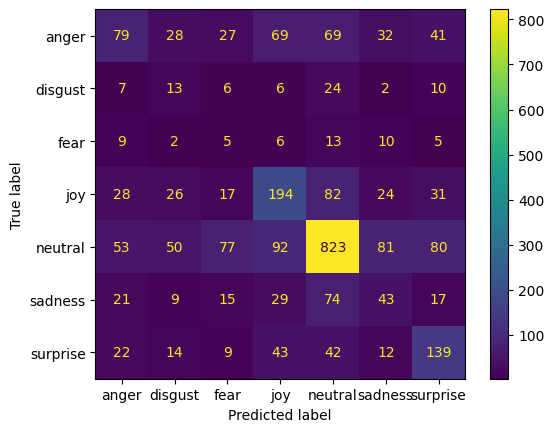

In [74]:
y_pred_svm = svm_linear_clf_balanced_weights.predict(test_tfidf_vectors)

report = classification_report(test_labels,y_pred_svm,digits = 3, target_names = svm_linear_clf_balanced_weights.classes_)
print('Class_weight BoW TFIDF SVM LINEAR ----------------------------------------------------------------')
print(report)

print('Class_weight Confusion matrix SVM')
print(svm_linear_clf_balanced_weights.classes_)
cf_matrix_svm = confusion_matrix(test_labels,y_pred_svm)
print(cf_matrix_svm)
import matplotlib.pyplot as plt
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_svm, display_labels=svm_linear_clf_balanced_weights.classes_)
display.plot()

If we compare these results with the downsampled classifier, we see that the precision for ```neutral``` scores a bit lower: .73 against .75 but the recall scores a lot higher: .65 against .44. Still the recall is lower than for the original classifier (.86) and also the f1 score is a bit lower: .69 against .73.

As for the other categories, we only see small mixed differences. The poor categories improved somewhat.

### 3.2 Adjusting the C-value

Sklearn also has a regulation parameter for the C-value for an SVM classifier. This parameter balances the effort to maximize the margin between correct and incorrect cases over all the data and the penalty for any misclassification. In a SVM, you are optimizing two things: a hyperplane with the largest minimum margin, and a hyperplane that correctly separates as many instances as possible. The former makes sure that correct and incorrect cases are separated as far as possible, whereas the latter makes sure that outliers are also classified correctly. The problem is that you will not always be able to get both things and this depends on the data at hand.

The next image illustrates this.

<img src="images/c-value-1.png" width="300" height="400">

To the left you have a low C which gives you a pretty large minimum margin (purple). However, this requires that we neglect the blue circle outlier that we have failed to classify correctly. On the right you have a high C. Now you will not neglect the outlier but end up with a much smaller margin. 

Depending on the data, either a high or low value works better. In the next case a large value works best because a group of correct cases gets included for a similar max margin:

<img src="images/c-value-2.png" width="300" height="400">

However, in the following case a low value works better because the smallest margin sacrifices only a single correct case:

<img src="images/c-value-3.png" width="300" height="400">

The default value for C is 1 in Sklearn. If you have a lot of noisy observations you should decrease it: decreasing C corresponds to more regularization.
LinearSVC and LinearSVR are less sensitive to C when the classifier becomes large (many features and a lot of data), and prediction results stop improving after a certain threshold. Meanwhile, larger C values will take more time to train, sometimes up to 10 times longer: [See the Sklearn website for more details](https://scikit-learn.org/stable/modules/svm.html)

To summarise: h higher C-value (upto 100) forces the model to have more recall (try to include all cases), whereas a lower C-value (down to 0.01) would make the system differentiate classes better and be more precise.

In [75]:
### Testing C-values

Credits to: https://www.geeksforgeeks.org/machine-learning/what-is-the-influence-of-c-in-svms-with-linear-kernel/

What is the influence of C in SVMs with linear kernel?

Support Vector Machines (SVMs) are powerful machine learning algorithms used for classification and regression tasks. When dealing with linearly separable data, SVMs use a linear kernel to find the optimal hyperplane that separates the classes. A crucial parameter in this process is C, which plays a significant role in shaping the decision boundary.

The parameter C in Support Vector Machines (SVMs) with a linear kernel controls the trade-off between the margin of the decision boundary and the accuracy of classifying the training data. Essentially, C determines how much the SVM should penalize misclassifications, influencing the complexity and accuracy of the model.

 A higher C value makes the model aim for fewer misclassifications by using a smaller margin, while a lower C allows more misclassifications with a wider margin.
How C Parameter in SVM Works?
The parameter C is a regularization parameter that balances two competing goals:

Maximizing the margin (the distance between the hyperplane and the nearest data points).
Minimizing the number of misclassifications in the training data.
Now, this is what c values convey:

High C Values: A high value of C means that the SVM will be heavily penalized for any misclassifications. This leads to a narrower margin, as the model will try to classify all training points correctly, even if it results in a more complex decision boundary. In practice, this can lead to overfitting, where the model performs well on the training data but poorly on new, unseen data.
Low C Values: Conversely, a low value of C means that the SVM will be less penalized for misclassifications. This results in a wider margin, leading to a simpler decision boundary. While this can reduce overfitting, it may also reduce the training accuracy, as some points may be misclassified to achieve a larger margin.

The next code demonstrates how varying the C value in an SVM model with an linear kernel affects decision boundaries and model accuracy. We generate synthetic data, train the model with different C values, and plot both the decision boundaries for each C and the corresponding accuracy on a log-scale graph. Lower C values result in smoother boundaries, favoring generalization, while higher C values create tighter boundaries, which may overfit.

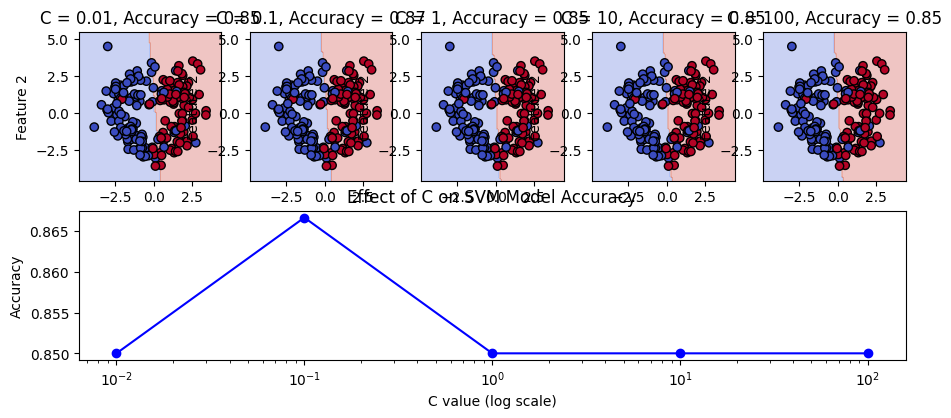

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic data (two classes)
X, y = datasets.make_classification(
    n_samples=200, n_features=2, n_informative=2, n_redundant=0, 
    n_clusters_per_class=2, flip_y=0.1, class_sep=1.5, random_state=42
)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define different C values to test
C_values = [0.01, 0.1, 1, 10, 100]

# Plotting setup
plt.figure(figsize=((800/75), (800/75)/2.5))

# Initialize list to store accuracies for plotting
accuracies = []

# Train and plot SVM for each C value
for i, C in enumerate(C_values, 1):
    # Initialize SVM model with Linear kernel and specified C value
    model = SVC(C=C, kernel='linear')
    model.fit(X_train, y_train)
    
    # Predict on test set and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Plot decision boundary
    plt.subplot(2, len(C_values), i)
    plt.title(f'C = {C}, Accuracy = {accuracy:.2f}')
    
    # Create a grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and scatter plot of data points
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Plot accuracies vs C values
plt.subplot(2, 1, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('C value (log scale)')
plt.ylabel('Accuracy')
plt.title('Effect of C on SVM Model Accuracy')
plt.savefig('Effect of C on SVM Model Accuracy.jpeg',bbox_inches='tight',dpi = 75)

As C increases (1, 10, and 100), the decision boundary becomes increasingly non-linear, with more bends and curves. This suggests that the SVM is attempting to fit the training data more precisely, even at the risk of overfitting. When C is small (0.01 and 0.1), the decision boundary is linear, indicating that the SVM is not trying to capture complex patterns in the data.

The accuracy of the model appears to be relatively stable across different values of C. The optimal value of C depends on the specific dataset and the desired trade-off between model complexity and accuracy. Cross-validation is a common technique to find the best C value by evaluating the model's performance on a validation set.

# End of this notebook